In [85]:
from smr import File
import numpy as np
from matplotlib import pyplot as plt


In [86]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1218_Adapt.smr'
# f_name = '/mnt/data/kkarbasi/SimpleSpike-Felix/Felix 2006.09.06/Felix 2006.09.06 1313 List.smr'

In [94]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)


In [95]:
voltage_chan = smr_content.get_channel(0)
# HE_chan = smr_content.get_channel(1)
# VE_chan = smr_content.get_channel(2)

In [96]:
from kaveh.sorting.spikesorter import SimpleSpikeSorter
# Time range of data to process:
t_0 = 0 #s
t_end = 5 #s

idx_0 = int(np.round(t_0 / voltage_chan.dt))
idx_end = int(np.round(t_end / voltage_chan.dt))
prange = slice(idx_0, idx_end)
sss = SimpleSpikeSorter(voltage_chan.data[prange], voltage_chan.dt)
sss.run()

In [97]:
sss.aligned_spikes.shape


(91, 50)

<IPython.core.display.Javascript object>


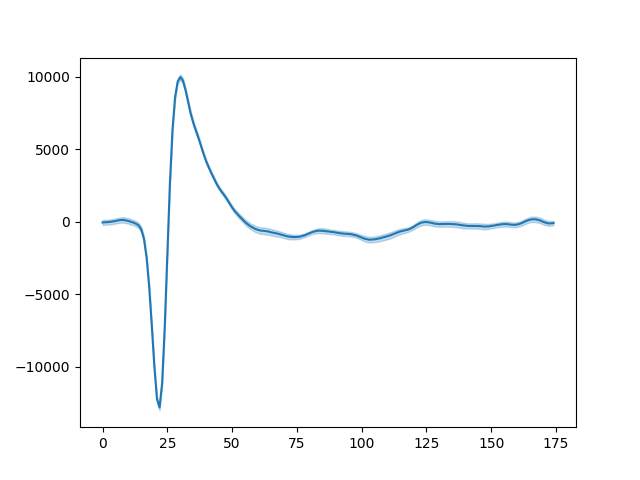

<IPython.core.display.Javascript object>


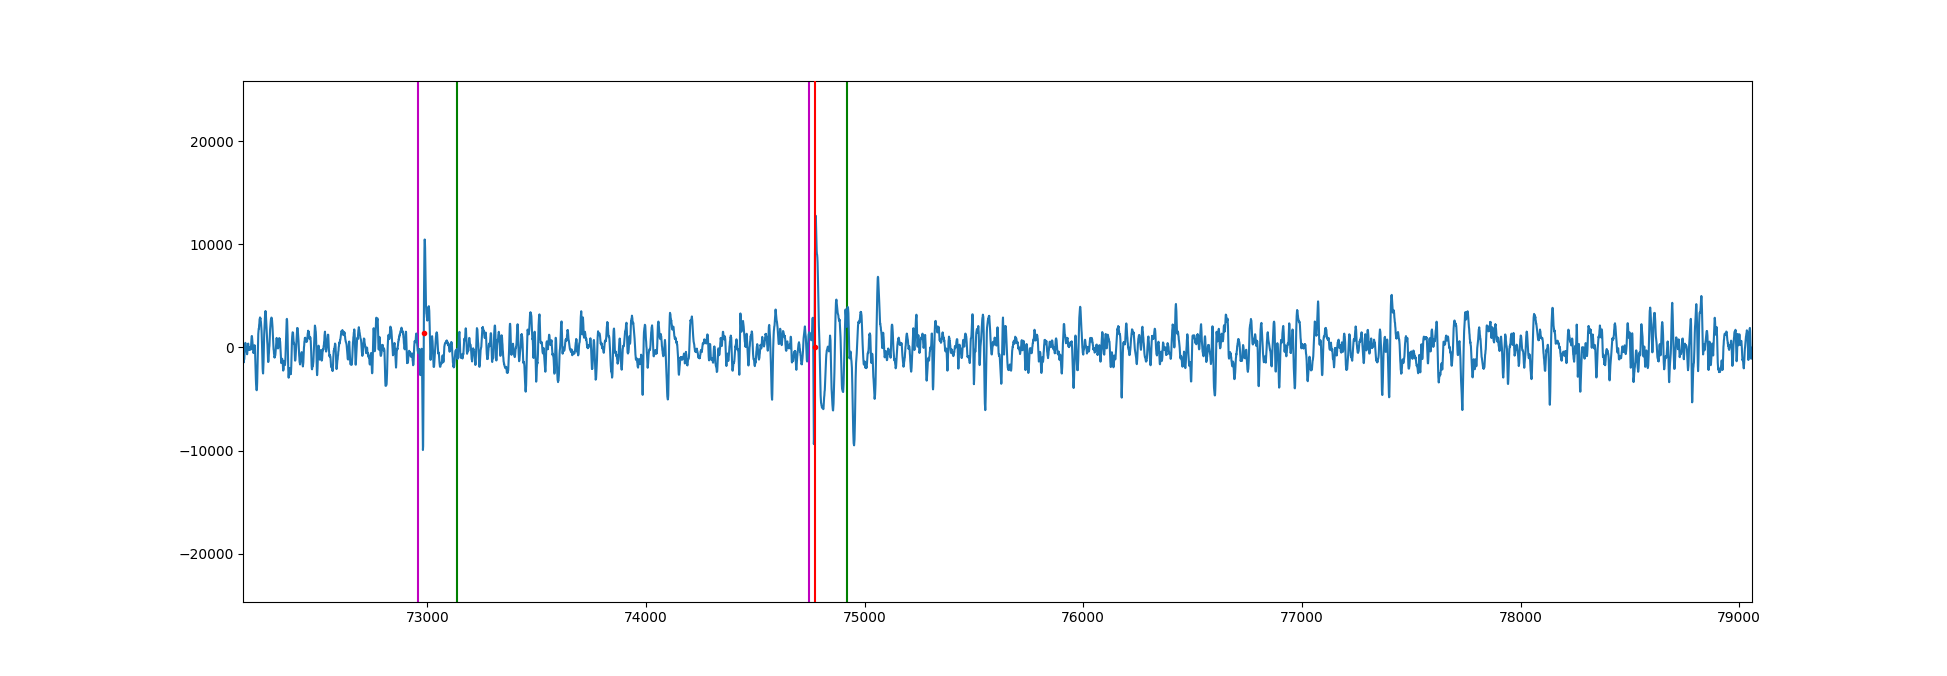

In [100]:
# Spike window (in seconds)
pre = 0.0005
post = 0.003

sss.set_spike_window(pre, post)
sss.plot_spike_waveforms_average()
sss.plot_spike_peaks(figsize=(5,3))

In [101]:
from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_spiketrain = np.array(seg.spiketrains[0])
cs_spiketrain = np.int32(cs_spiketrain/sss.dt)
cs_spiketrain = cs_spiketrain[np.where(np.logical_and(cs_spiketrain >= idx_0, cs_spiketrain < idx_end))]
cs_spike_indices = np.unique(closest_argmin(cs_spiketrain, sss.spike_indices))

In [102]:
cs_spike_indices.shape

(6,)

In [103]:
from kaveh.plots import axvlines
axvlines(plt.gca(), sss.spike_indices[cs_spike_indices], color='r', zorder=10)

<IPython.core.display.Javascript object>


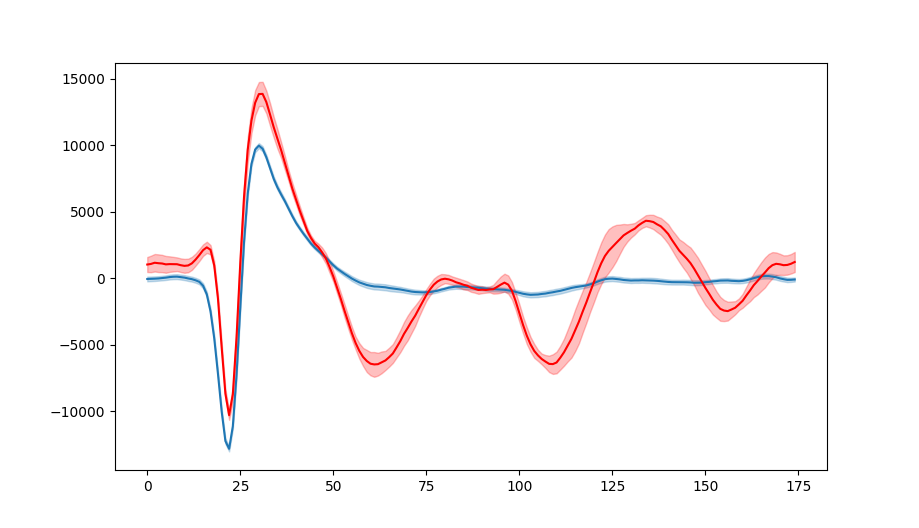

In [104]:
sss._align_spikes()
sss.plot_spike_waveforms_average()

pre_index = int(np.round(sss.pre_window / sss.dt))
post_index = int(np.round(sss.post_window / sss.dt))


cs_aligned_spikes = np.array([sss.voltage[i - pre_index : i + post_index ] for i in sss.spike_indices[cs_spike_indices]])

cs_spikes_avg = np.mean(cs_aligned_spikes, axis = 0)
cs_spikes_std = np.std(cs_aligned_spikes, axis = 0)/np.sqrt(cs_aligned_spikes.shape[0])
x = np.arange(0, cs_aligned_spikes.shape[1])

l = plt.plot(x, cs_spikes_avg, 'r')
plt.fill_between(x, cs_spikes_avg - cs_spikes_std, cs_spikes_avg + cs_spikes_std, color=l[0].get_color(), alpha=0.25)





<IPython.core.display.Javascript object>


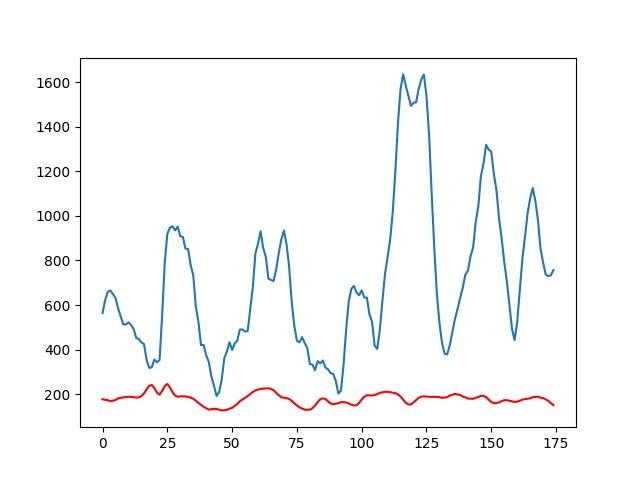

In [105]:
plt.figure()
plt.plot(cs_spikes_std)

# plt.figure()
plt.plot(np.std(sss.aligned_spikes, axis = 0)/np.sqrt(sss.aligned_spikes.shape[0]), 'r')

<IPython.core.display.Javascript object>


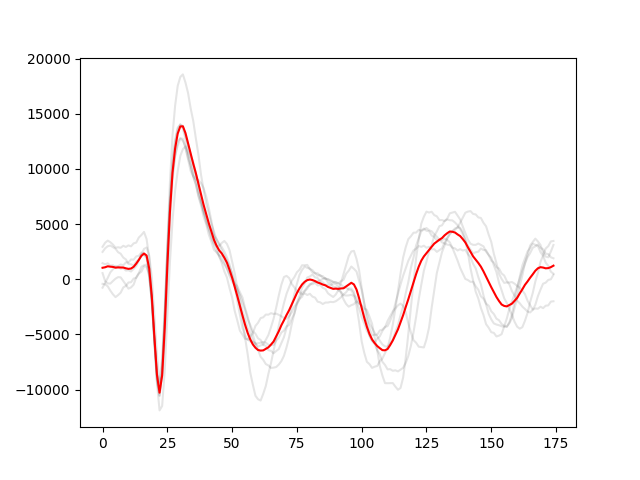

In [106]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

<IPython.core.display.Javascript object>


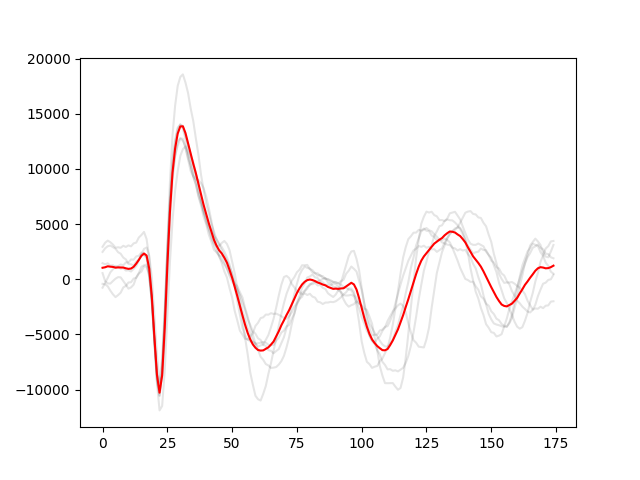

<IPython.core.display.Javascript object>


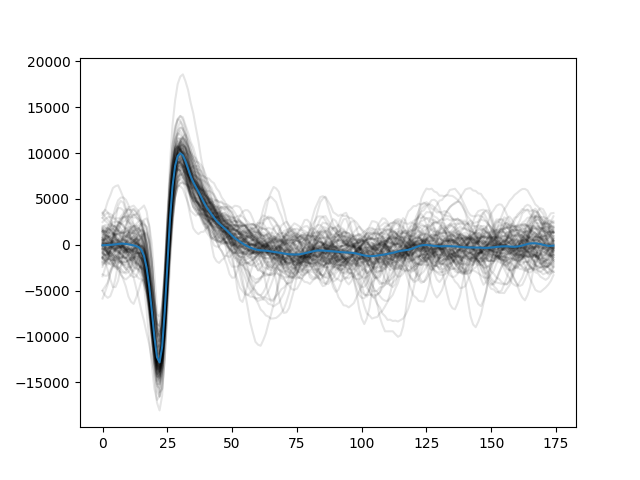

In [107]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

plt.figure()

for ss in sss.aligned_spikes[0:100]:
        plt.plot(ss, alpha=0.10, color='k')
plt.plot(np.mean(sss.aligned_spikes[0:100], axis=0))
